In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ln -s /content/drive/My\ Drive/ mydrive

In [3]:
import nltk
nltk.download("brown")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from mydrive.Codes.brown import Brown

In [5]:
vocab, sentences = Brown().get_limited_vocab(vocab_size=200)
print("Vocab Size : {}".format(len(vocab)))
print("Corpus length : {}".format(len(sentences)))

Vocab Size : 201
Corpus length : 56610


In [9]:
class NeuralNetwork:

  def __init__(self):
    pass

  def forward_prop(self, inputs, weights):
    """
    ----------------------------------------------------
    Description :
    Computes the dot product between two vectors 

    Input :
    inputs : a numpy ndarray 
    weights : a numpy ndarray

    Return :
    z : a numpy ndarray 
    """
    z = np.dot(inputs, weights)
    
    return z


  def softmax(self, z):

    """
    ----------------------------------------------
    Description :
    Function to calculate the softmax function of a vector

    Input :
    z : a numpy ndarray

    Return :
    soft : a numpy ndarray
    ----------------------------------------------
    """
    z = z - z.max()
    soft = np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims = True)
    return soft


  def train(self, vocab, sentences, epochs=20, lr = 0.01):

    """
    -------------------------------------------------
    Description:
    Function to train a neural network

    Input :
    vocab : dict object of pair "word":word_idx
    sentences : list of list containing integers
    epochs : number of times to turn the loop
    lr : learning rate of the neural network

    Return :
    W : dict object containing the weights of the neural network
    ------------------------------------------------
    """

    start_idx = vocab["START"]
    end_idx = vocab["END"]
    V = len(vocab)
    D = 100

    losses = []
    
    W1 = np.random.randn(V, D) / np.sqrt(V)
    W2 = np.random.randn(D, V) / np.sqrt(V)

    for epoch in range(epochs):
      
      epoch_loss = 0
      
      for sentence in tqdm(sentences):

        sentence = [start_idx] + sentence + [end_idx]
        n = len(sentence)
        inputs = np.zeros((n - 1 , V))
        outputs = np.zeros((n - 1, V))

        inputs[np.arange(n-1), sentence[:n-1]] = 1
        outputs[np.arange(n-1), sentence[1:]] = 1

        z1 = self.forward_prop(inputs, W1)
        a1 = np.tanh(z1)

        z2 = self.forward_prop(a1, W2)
        a2 = self.softmax(z2)

        loss = -np.sum(outputs * np.log(a2)) / (n - 1)
        
        
        W2 = W2 - lr * np.dot(a1.T, (a2 - outputs))
        hidden = np.dot((a2 - outputs), W2.T)*(1 - a1*a1)
        W1 = W1 - lr * inputs.T.dot(hidden)

        losses.append(loss)
        epoch_loss += loss

      epoch_loss /= len(sentences)

      print("Epoch : {}, Loss : {}".format(epoch, epoch_loss))

    
    W = {"W1" : W1, "W2": W2}

    return W
      



In [10]:
neural_weights = NeuralNetwork().train(vocab, sentences)


Epoch : 0, Loss : 2.8088794651305533



Epoch : 1, Loss : 2.967092805210212



Epoch : 2, Loss : 3.09464983522169



Epoch : 3, Loss : 3.1865417051353706



Epoch : 4, Loss : 3.2471163993717966



Epoch : 5, Loss : 3.2998795553357634



Epoch : 6, Loss : 3.341377806427176



Epoch : 7, Loss : 3.3813768008430114



Epoch : 8, Loss : 3.4124141545821516



Epoch : 9, Loss : 3.444069210388224



Epoch : 10, Loss : 3.4702876377356793



Epoch : 11, Loss : 3.4985066211245734



Epoch : 12, Loss : 3.515844685394385



Epoch : 13, Loss : 3.5331792519071055



Epoch : 14, Loss : 3.5503470621269386



Epoch : 15, Loss : 3.5673552413997682



Epoch : 16, Loss : 3.5788686895151773



Epoch : 17, Loss : 3.588778983377003



Epoch : 18, Loss : 3.5996895960756974



Epoch : 19, Loss : 3.6104505307945107


In [15]:
def get_bigram_probs(start_idx, end_idx, sentences, V, smoothning = 1.00):

  """
  ----------------------------------------
  Description :
  Function to calculate the bigram probability of a sentence

  Input :
  start_idx : index of "START" tag
  end_idx : index of "END" tag
  sentences : list of list containing integers
  V : vocab size
  smoothning : amount of smoothning to be applied to the bigram probabilities

  Return :
  bigram_probs : A numpy ndarray of shape (V x V) containing the bigram probability of the sentences
  ----------------------------------------
  
  """

  bigram_probs = np.ones((V, V))

  for sentence in sentences:
    for i in range(len(sentence)):

      if  i == 0:
        bigram_probs[start_idx, sentence[i]] += 1
      elif i == len(sentence) - 1:
        bigram_probs[sentence[i], end_idx] += 1
      
      else:
        bigram_probs[sentence[i-1], sentence[i]] += 1


  bigram_probs /= bigram_probs.sum(axis = 1, keepdims=True)
  return bigram_probs

In [16]:
ideal_bigram_probs = get_bigram_probs(vocab["START"], vocab["END"], sentences, len(vocab))

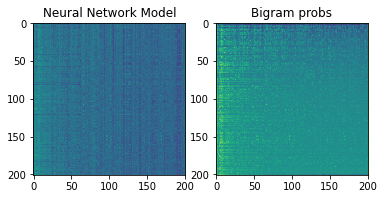

In [19]:
plt.subplot(1,2,1)
plt.title("Neural Network Model")
plt.imshow(np.tanh(neural_weights["W1"]).dot(neural_weights["W2"]))
plt.subplot(1,2,2)
plt.title("Bigram probs")
plt.imshow(np.log(ideal_bigram_probs))
plt.show()

# Conclusion 

* The above plot shows the fact that the two weights could have been similar if we had trained the network for a longer time . 

* The pattern is quite evident if we see the image thoroughly .




